In [15]:
import pandas as pd
import numpy as np

# Load the analyzed data
modelling_table = pd.read_csv("analyzed_data_sep_sea.csv")

modelling_table['valid_datetime'] = pd.to_datetime(modelling_table['valid_datetime'])
modelling_table['ref_datetime'] = pd.to_datetime(modelling_table['ref_datetime'])

# Define the Pinball function
def pinball(y, q, alpha):
    return np.maximum(y - q, 0) * alpha + np.maximum(q - y, 0) * (1 - alpha)

# Calculate the Pinball Score for each season and quantile
def pinball_score(modelling_table):
    seasons = ['spring', 'summer', 'autumn', 'winter']
    annual_scores = []
    for season in seasons:
        score = []
        for quantile in range(10, 100, 10):
            alpha = quantile / 100
            q = modelling_table[f"{season}_q{quantile}"]
            y = modelling_table["total_generation_MWh"]
            pinball_loss = pinball(y, q, alpha).mean()
            rounded_loss = round(pinball_loss, 2)
            score.append(rounded_loss)
            #print(f"{season} season pinball loss for q{quantile} = {rounded_loss:.2f}")
        average_loss = round(sum(score) / len(score), 2)
        annual_scores.append(average_loss)
        print(f"{season} season average pinball loss = {average_loss:.2f}\n")

    # Calculate and print the annual average pinball score
    annual_average_loss = round(sum(annual_scores) / len(annual_scores), 2)
    print(f"Annual average pinball loss = {annual_average_loss:.2f}")

# Calculate and print the Pinball Score
pinball_score(modelling_table)

spring season average pinball loss = 27.76

summer season average pinball loss = 30.83

autumn season average pinball loss = 27.02

winter season average pinball loss = 24.18

Annual average pinball loss = 27.45


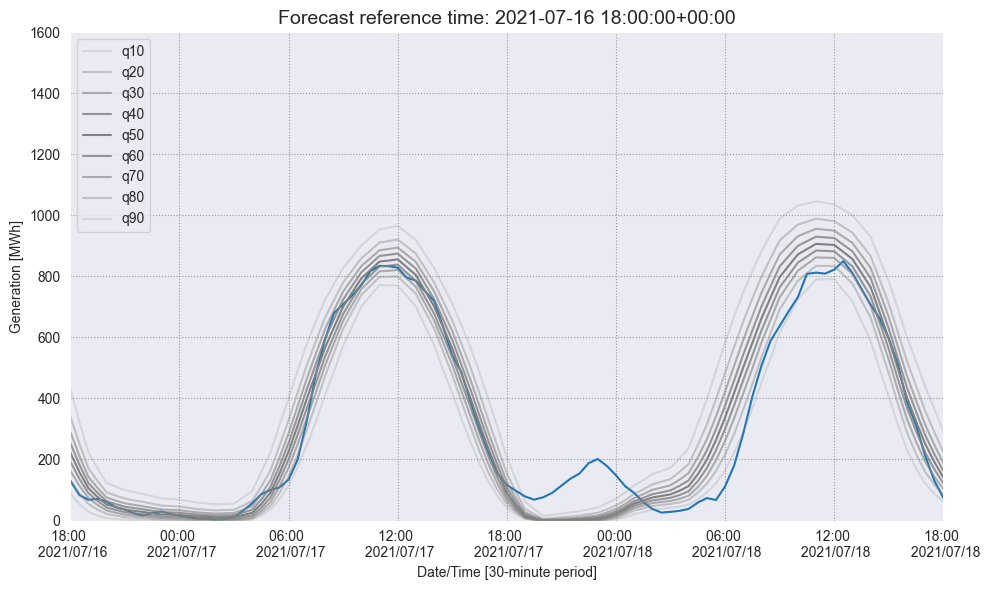

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# ref_datetimeの条件に一致する行を抽出
ref_time = modelling_table["ref_datetime"] == modelling_table["ref_datetime"][116015]
filtered_data = modelling_table[ref_time]

# 116015番目の行の月を取得し、季節を決定
month_116015 = modelling_table.loc[116015, "month"]
seasons = {'spring': [3, 4, 5], 'summer': [6, 7, 8], 'autumn': [9, 10, 11], 'winter': [12, 1, 2]}
season = next((s for s, months in seasons.items() if month_116015 in months), None)

plt.figure(figsize=(10, 6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax1 = sns.lineplot(data=filtered_data, x="valid_datetime", y="total_generation_MWh")

for quantile in range(10, 100, 10):
    sns.lineplot(data=modelling_table,
                 x=filtered_data["valid_datetime"],
                 y=filtered_data[f"{season}_q{quantile}"],
                 color='gray',
                 alpha=1 - abs(50 - quantile) / 50,
                 label=f'q{quantile}')

plt.ylim(0, 1600)
plt.xlim(filtered_data['valid_datetime'].min(), filtered_data['valid_datetime'].max())
#plt.xticks(modelling_table['valid_datetime'][::6])
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M \n %Y/%m/%d"))
plt.xlabel('Date/Time [30-minute period]')
plt.ylabel('Generation [MWh]')
plt.title(f"Forecast reference time: {filtered_data['ref_datetime'].iloc[0]}", fontsize=14)
plt.tight_layout()

plt.show()

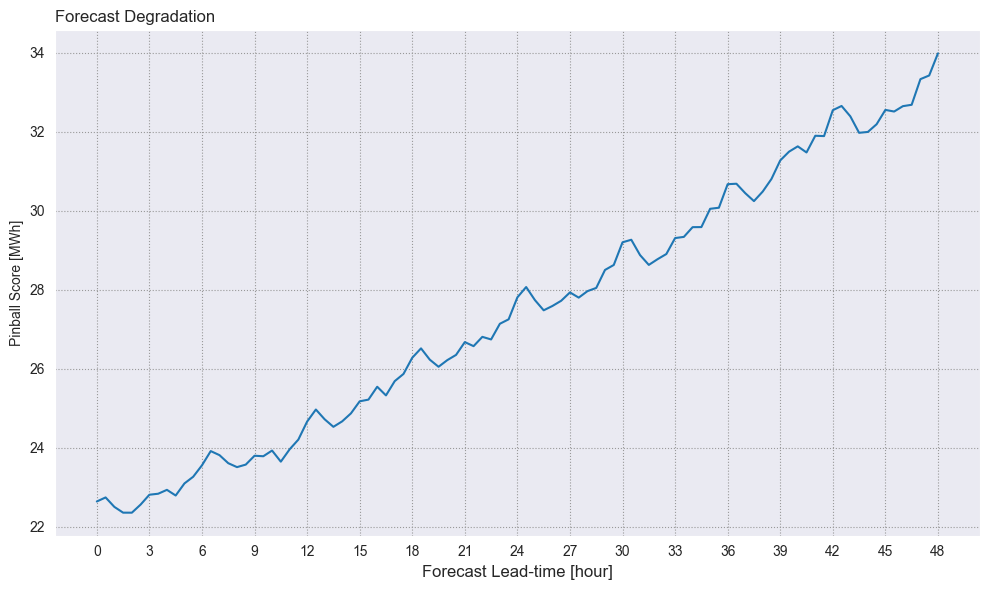

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Load the analyzed data
modelling_table = pd.read_csv("analyzed_data_sep_sea.csv")
modelling_table['valid_datetime'] = pd.to_datetime(modelling_table['valid_datetime'])
modelling_table['ref_datetime'] = pd.to_datetime(modelling_table['ref_datetime'])
modelling_table['lead_time'] = (modelling_table['valid_datetime'] - modelling_table['ref_datetime']).dt.total_seconds() / 3600

# Define the Pinball function
def pinball(y, q, alpha):
    return round((y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q),2)

# Calculate the Pinball Score for each season and quantile
def pinball_score(df):
    seasons = ['spring', 'summer', 'autumn', 'winter']
    score = []
    for quantile in range(10, 100, 10):
        alpha = quantile / 100
        q = df[[f"{season}_q{quantile}" for season in seasons]].mean(axis=1)
        y = df["total_generation_MWh"]
        pinball_loss = pinball(y, q, alpha).mean()
        score.append(pinball_loss)
    return np.mean(score)

# Calculate the Pinball Score for each lead time
forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)

plt.figure(figsize=(10, 6))
ax1 = forecast_performance.plot()
ax1.set_ylabel('Pinball Score [MWh]')
ax1.set_xlabel('Forecast Lead-time [hour]', fontsize=12)

# x軸の刻みを変更
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=3))  # 3時間ごとに調整

ax1.set_title('Forecast Degradation', loc='left')
plt.tight_layout()
plt.show()
